In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/NewsStocksData
!ls

Mounted at /content/drive/
/content/drive/MyDrive/NewsStocksData
catboost_info  new.xlsx  yahoo_data.xlsx


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.8 MB/s eta 0:00:00


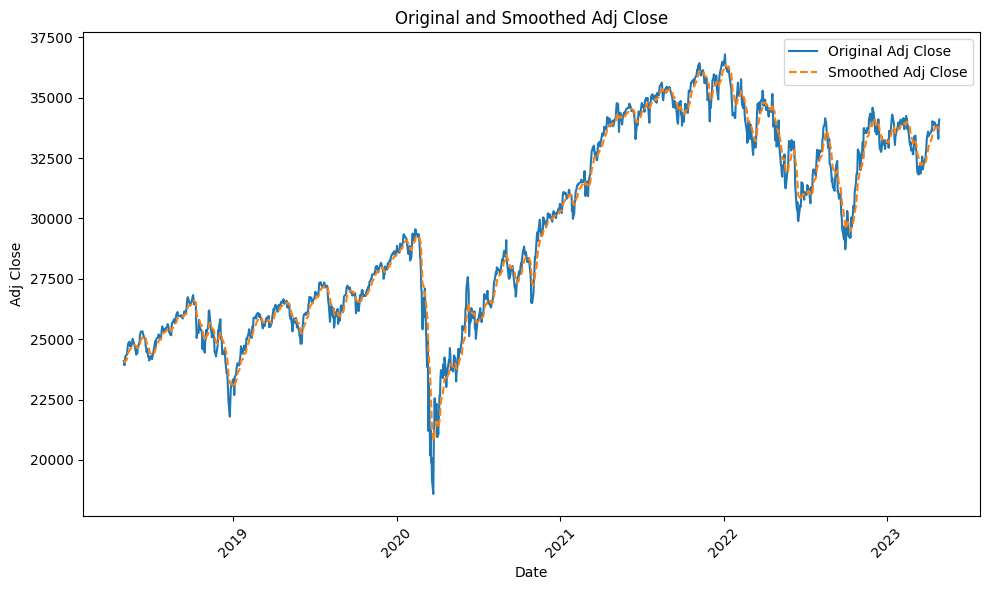

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def single_exponential_smoothing(data, alpha):
    smoothed_data = [data[0]]

    for i in range(1, len(data)):
        smoothed_value = alpha * data[i] + (1 - alpha) * smoothed_data[-1]
        smoothed_data.append(smoothed_value)

    return smoothed_data

df = pd.read_excel('new.xlsx')
data = df['Adj Close**'].tolist()
alpha = 0.2
smoothed_data = single_exponential_smoothing(data, alpha)
df['Smoothed Adj Close'] = smoothed_data

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Adj Close**'], label='Original Adj Close')
plt.plot(df['Date'], df['Smoothed Adj Close'], label='Smoothed Adj Close', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('Original and Smoothed Adj Close')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22066.729, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13734.649, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13756.499, Time=0.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13702.975, Time=1.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=2.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13729.234, Time=2.66 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=13702.305, Time=3.25 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=4.43 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=13686.434, Time=3.77 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=13654.858, Time=2.34 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=13656.545, Time=3.70 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=13656.676, Time=3.87 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


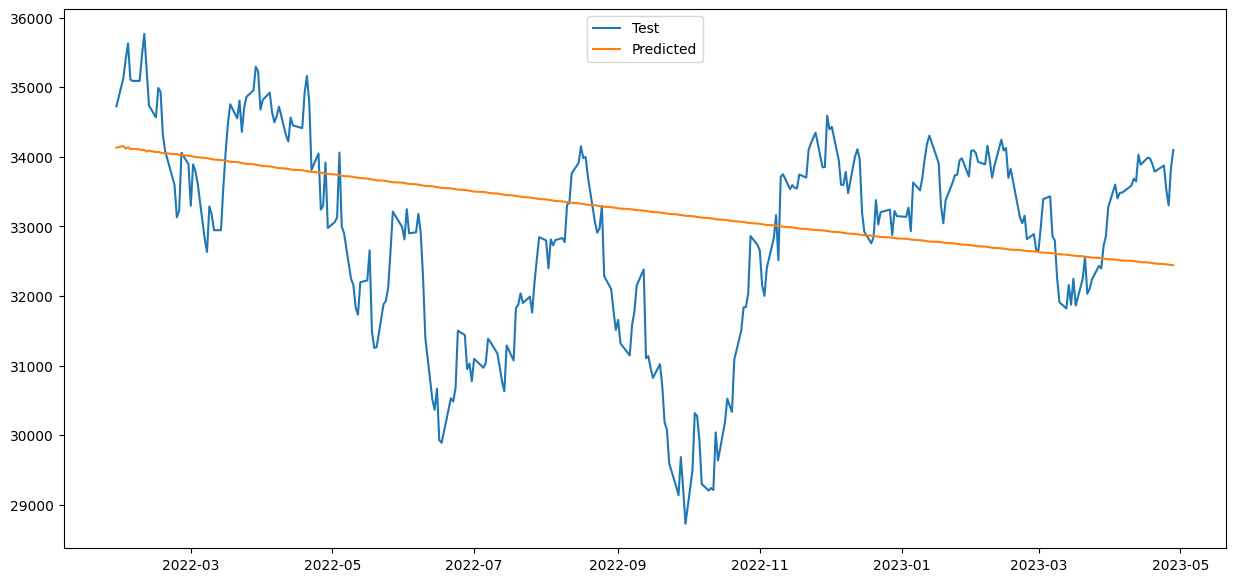

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

TEST_SIZE = int(len(df)*0.25)

X = df[['Adj Close**']]
X = X.set_index(df['Date'])
X = X.dropna()
train, test = X[0:-TEST_SIZE], X[-TEST_SIZE:]

model = auto_arima(train, start_p=0, start_q=0, max_p=7, max_q=7, seasonal=False,
d=0, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)
model.summary()

forecast = model.predict(TEST_SIZE)
forecast = pd.DataFrame(forecast)
forecast = forecast.set_index(test.index)

plt.rcParams["figure.figsize"] = [15, 7]
plt.plot(test, label='Test')
plt.plot(forecast, label='Predicted')
leg = plt.legend(loc='upper center')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

RMSE = (mean_squared_error(test, forecast))**0.5

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print('RMSE', RMSE)
print('The Mean Absolute Percentage Error is: %.3f' % mape(np.array(test), forecast),'%.')

RMSE 1524.3697871612003
The Mean Absolute Percentage Error is: 3.775 %.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.6 MB/s eta 0:00:00


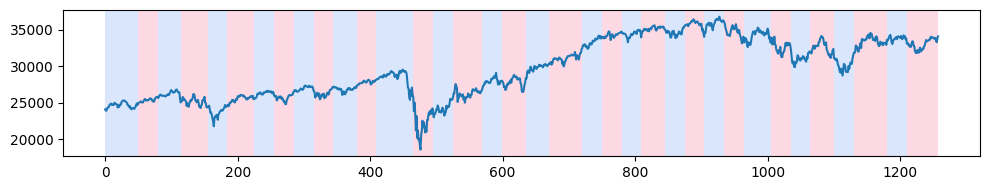

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ruptures as rpt

df = pd.read_excel("new.xlsx")
time_series_data = df['Adj Close**'].values
model = "l2"
algo = rpt.Pelt(model=model,min_size=30).fit(time_series_data)
penalty_value = 10
result = algo.predict(pen=penalty_value)
rpt.display(time_series_data, result)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [ ]:
price = pd.read_csv('AAPL.csv')
plt.figure(figsize=(9, 6))
plt.plot(price.index, price['adjclose'], label='Adj Close Price')
#plt.title('Adjusted Close Price Over Time')
plt.xlabel('Days from the start of observations')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(price['adjclose'])


In [ ]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

kpss_test(price['adjclose'])

In [ ]:
price["adjclose_diff"] = price["adjclose"] - price["adjclose"].shift(1)
price["adjclose_diff"].dropna().plot(figsize=(9, 6))
plt.xlabel('Days from the start of observations')
plt.ylabel('Adjusted Close Price Change')

In [ ]:
adf_test(price["adjclose_diff"].dropna())
kpss_test(price["adjclose_diff"].dropna())